# Clustering ETFs

This notebook contains the required code to perform the pairs selection stage. First, it implements the three following search techniques:

- No clustering
- Clustering by category
- Clustering with OPTICS

In addittion, it considers the proposed pairs selection rules to apply on top.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

### Import Libraries

In [2]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE

from keras.layers import Dense, Flatten, LSTM, Dropout

### Import Classes

In [4]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [5]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Commodity ETFs Dataset

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [6]:
# intraday
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened.pickle')
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')
subsample = 2500
min_half_life = 78 # number of points in a day
max_half_life = 20000 #~number of points in a year: 78*252
file_extension = 'intraday'

In [7]:
len(df_prices.columns)

116

In [242]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2013',
                                                             '31-12-2015'),
                                                            ('01-01-2016',
                                                             '31-12-2016'),
                                                            remove_nan=True)
train_val_split = '01-01-2017'

Total of 116 tickers
Total of 105 tickers after removing tickers with Nan values


In [243]:
len(df_prices_train)+len(df_prices_test)

78222

# 1. No Clustering

In [ ]:
no_cluster_series = pd.Series(0,index = df_prices_train.columns)
pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.01,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample,
                                                            )

In [93]:
print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))
#with open('data/etfs/pickle/2014-2018/pairs_no_clustering_'+file_extension+'_only_coint.pickle', 'wb') as f:
#    pickle.dump(pairs_all_a_all, f)

Out of 6670.0 possible combinations


# 2. Clustering by Category

In [197]:
segment_mapper = {
                'Commodities: Agriculture':'Agriculture',
                'Commodities: Agriculture Cocoa':'Agriculture',
                'Commodities: Agriculture Coffee':'Agriculture',
                'Commodities: Agriculture Corn':'Agriculture',
                'Commodities: Agriculture Cotton':'Agriculture',
                'Commodities: Agriculture Grains':'Agriculture',
                'Commodities: Agriculture Livestock':'Agriculture',
                'Commodities: Agriculture Softs':'Agriculture',
                'Commodities: Agriculture Soybeans':'Agriculture',
                'Commodities: Agriculture Sugar':'Agriculture',
                'Commodities: Agriculture Wheat':'Agriculture',
                'Equity: Global Water':'Agriculture',
                'Commodities: Broad Market':'Broad Market',
                'Commodities: Broad Market Metals':'Broad Market',
                'Commodities: Energy':'Energy',
                'Commodities: Energy Crude Oil':'Energy',
                'Commodities: Energy Gasoline':'Energy',
                'Commodities: Energy Natural Gas':'Energy',
                'Inverse Commodities: Energy Crude Oil':'Energy',
                'Inverse Commodities: Energy Natural Gas':'Energy',
                'Leveraged Commodities: Energy Crude Oil':'Energy',
                'Leveraged Commodities: Energy Natural Gas':'Energy',
                'Equity: U.S. MLPs':'Energy',
                'Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Natural Gas':'Energy',
                'Equity: U.S. Oil & Gas Exploration & Production':'Energy',
                'Equity: U.S. Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas Exploration & Production':'Energy',
                'Equity: Global Energy':'Energy',
                'Equity: Global Nuclear Energy':'Energy',
                'Equity: Global Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas':'Energy',
                'Equity: U.S. Natural Gas':'Energy',
                'Equity: Global Coal':'Energy',
                'Leveraged Equity: U.S. Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Equity: China Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Commodities: Industrial Metals':'Industrial Metals',
                'Commodities: Industrial Metals Aluminum':'Industrial Metals',
                'Commodities: Industrial Metals Copper':'Industrial Metals',
                'Commodities: Industrial Metals Lead':'Industrial Metals',
                'Commodities: Industrial Metals Nickel':'Industrial Metals',
                'Commodities: Industrial Metals Tin':'Industrial Metals',
                'Equity: U.S. Metals & Mining':'Industrial Metals',
                'Equity: Global Metals & Mining':'Industrial Metals',
                'Commodities: Precious Metals':'Precious Metals',
                'Commodities: Precious Metals Gold':'Precious Metals',
                'Commodities: Precious Metals Palladium':'Precious Metals',
                'Commodities: Precious Metals Platinum':'Precious Metals',
                'Commodities: Precious Metals Silver':'Precious Metals',
                'Inverse Commodities: Precious Metals Gold':'Precious Metals',
                'Inverse Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Commodities: Precious Metals Gold': 'Precious Metals',
                'Leveraged Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Silver Miners':'Precious Metals',
                'Inverse Equity: Global Gold Miners':'Precious Metals'}

clustering_mapper = {'Agriculture':0,'Energy':1, 'Industrial Metals':2, 'Precious Metals':3, 'Broad Market': 4}

In [198]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

df_category = pd.DataFrame(data =df_prices_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
df_category['Category'] = df_category['Segment'].apply(lambda row: segment_mapper[row])
df_category['Category_cluster'] = df_category['Category'].apply(lambda row: clustering_mapper[row])
df_category = df_category.set_index('Ticker')

ticker_category_dict = pd.Series(df_category.Category.values,index=df_category.index).to_dict()
with open('data/etfs/pickle/ticker_category_dict.pickle', 'wb') as handle:
    pickle.dump(ticker_category_dict, handle)

In [208]:
print('Trading days: ', len(np.unique(df_prices_train.index.date))+len(np.unique(df_prices_test.index.date)))
print('Begin: ', df_prices_train.index.date[0])
print('End: ', df_prices_test.index.date[-1])
print('Samples: {}: {}-{}-{} '.format(len(df_prices_train+df_prices_test), len(df_prices_train[:train_val_split]),
                                      len(df_prices_train[train_val_split:]), len(df_prices_test)))
print(df_category['Category'].value_counts())
combinations = 0
for i,count in enumerate(df_category['Category'].value_counts().values):
    combinations += count*(count-1)
print('Possible number of pairs: ', combinations)

Trading days:  1006
Begin:  2015-01-02
End:  2018-12-31
Samples: 1006: 504-251-251 
Energy               63
Precious Metals      36
Agriculture          12
Broad Market         12
Industrial Metals     7
Name: Category, dtype: int64
Possible number of pairs:  5472


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_category.drop(['Category_cluster'],axis=1))

In [89]:
pairs_category, unique_tickers = series_analyser.get_candidate_pairs(
                                                            clustered_series=df_category['Category_cluster'],
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.01,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample,
                                                            )

pairs_found_category = len(pairs_category)
#with open('data/etfs/pickle/2012-2016/pairs_category_'+file_extension+'.pickle', 'wb') as f:
#    pickle.dump(pairs_category, f)

Cluster 5/5Found 86 pairs
The pairs contain 37 unique tickers
{'cointegration': 467, 'hurst_exponent': 2, 'None': 86, 'half_life': 1}


In [270]:
categories_found = pd.Series([ticker_category_dict[pair[0]] for pair in pairs_aux])
categories_found.value_counts()

Energy             40
Precious Metals    11
dtype: int64

# 3. Clustering using Usupervised Learning

## PCA on returns

**Obtain returns**

In [244]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DGL,...,SLVP,SOYB,UCI,UGAZ,UNL,URA,USCI,WEAT,YMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:40:00,0.001722,0.004083,0.000000,-0.000514,-0.000721,-0.009513,-0.000770,0.000351,0.000545,0.000685,...,-0.005767,0.0,0.0,-0.002564,-0.000595,0.002952,0.018385,-0.041933,-0.002254,-0.000428
2013-01-02 14:45:00,-0.003183,0.000245,-0.000358,0.000103,-0.000722,0.000722,-0.000732,0.000175,-0.002029,0.000000,...,0.000000,0.0,0.0,0.000000,-0.002382,-0.004415,0.000000,0.000000,0.000000,0.001285
2013-01-02 14:50:00,-0.003193,0.000000,0.000358,-0.000103,-0.000325,0.000108,0.000000,0.000053,0.000000,0.000000,...,0.003558,0.0,0.0,0.001542,0.000000,-0.001333,0.002700,0.019029,-0.001520,0.003423
2013-01-02 14:55:00,0.004271,0.000000,0.000322,0.002008,0.001409,-0.000830,0.001889,0.000631,-0.001845,0.000860,...,0.000000,0.0,0.0,-0.002002,0.000597,-0.006065,-0.001010,0.000934,0.003209,-0.003838
2013-01-02 15:00:00,0.003827,0.000000,0.000393,-0.000514,0.000722,0.001083,0.000770,0.000351,0.004451,0.002421,...,0.000000,0.0,0.0,-0.003138,0.000358,0.007445,0.001347,-0.000933,-0.002235,-0.005137


In [245]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  5460.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 5.

In [246]:
N_PRIN_COMPONENTS = 5
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns, 
                                                  random_state=0)#12)
print(explained_variance)

[2.34196784e-04 1.43615518e-04 9.93884260e-05 3.93501877e-05
 3.02258090e-05]


**Clustering**

In [241]:
def cluster_size(counts):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('ETFs within cluster', size=12)
    plt.ylabel('Cluster Id', size=12);

In [135]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(0.15,
                                                                                   3,
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 7
Pairs to evaluate: 186


In [247]:
# optics
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_OPTICS(X, df_returns, min_samples=3,
                                                                                   #max_eps=5, 
                                                                                   cluster_method='xi')

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30, max_eps=2,
       metric='euclidean', metric_params=None, min_cluster_size=None,
       min_samples=3, n_jobs=None, p=2, predecessor_correction=True, xi=0.05)
Clusters discovered: 13
Pairs to evaluate: 140


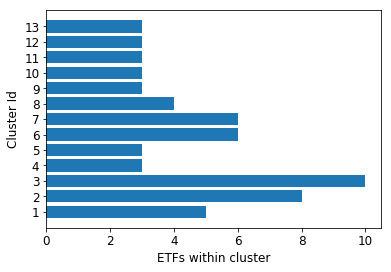

In [248]:
cluster_size(counts)

The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [249]:
print(counts)
print('Average cluster size: ', np.mean(counts))

2     10
1      8
6      6
5      6
0      5
7      4
12     3
11     3
10     3
9      3
8      3
4      3
3      3
dtype: int64
Average cluster size:  4.615384615384615


**Fundamental analysis for clusters**

In [250]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [251]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
   Ticker                                      Segment
96    DBS          Commodities: Precious Metals Silver
62    DGP  Leveraged Commodities: Precious Metals Gold
40   SIVR          Commodities: Precious Metals Silver
24    SLV          Commodities: Precious Metals Silver
64    UGL  Leveraged Commodities: Precious Metals Gold

Cluster 1:
   Ticker                                 Segment
55    DBP            Commodities: Precious Metals
59    DGL       Commodities: Precious Metals Gold
22    GLD       Commodities: Precious Metals Gold
39   GLTR            Commodities: Precious Metals
23    IAU       Commodities: Precious Metals Gold
44   PALL  Commodities: Precious Metals Palladium
32   PPLT   Commodities: Precious Metals Platinum
29   SGOL       Commodities: Precious Metals Gold

Cluster 2:
   Ticker                            Segment
69    BCM          Commodities: Broad Market
2    CORN      Commodities: Agriculture Corn
0     DBA           Commodities: Agriculture
77  

**Visualizing with t-sne**

In [262]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    # axis in the middle
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)
    #plt.axis('off')

    # etfs in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]-20, y[i]+12), size=15)

    # remaining etfs, not clustered
    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    # WARNING: elimintate outliers
    #outliers = ['DTO','SCO']
    outliers = ['DZZ', 'XME']
    to_remove_x = [x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    to_remove_y = [y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    x = np.array([i for i in x if i not in to_remove_x])
    y= np.array([i for i in y if i not in to_remove_y])

    plt.scatter(
        x,
        y,
        s=150,
        alpha=0.20,
        c='black'
    )
    #for i, ticker in enumerate(tickers):
    #    plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})
        
    #plt.title('OPTICS clusters visualized with t-SNE', size=16);
    plt.xlabel('t-SNE Dim. 1', position=(0.92,0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0,0.92), size=20)
    ax.set_xticks(range(-300, 301, 600))
    ax.set_yticks(range(-300, 301, 600))
    #plt.savefig('DBSCAN_2014_2018_eps0_15.png', bbox_inches='tight', pad_inches=0.01)
    plt.savefig('OPTICS_2013_2017.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # include connections - see quontopian

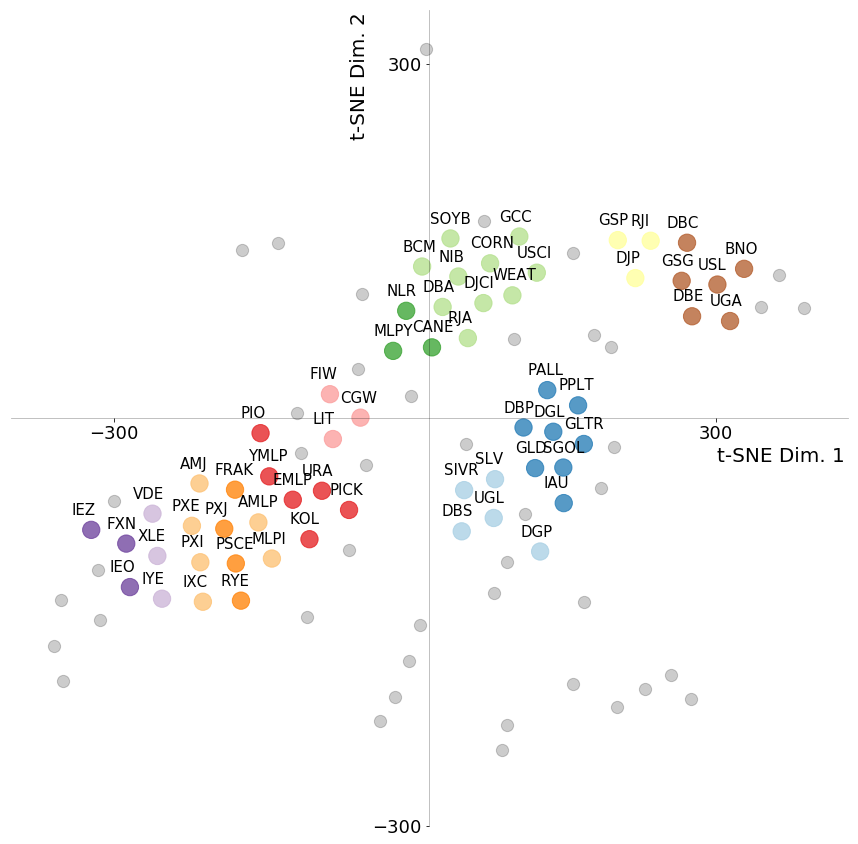

In [263]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

In [76]:
plt.rcParams.update({'font.size': 12})

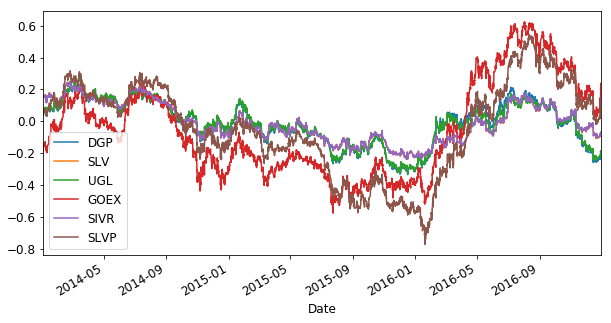

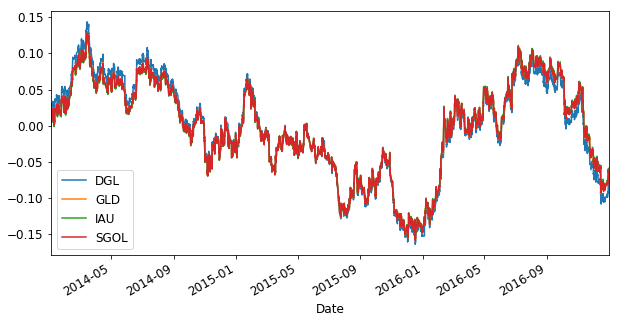

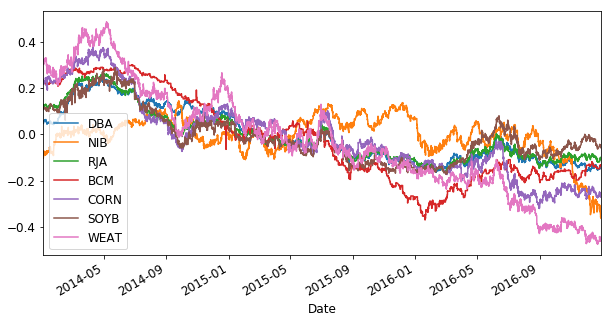

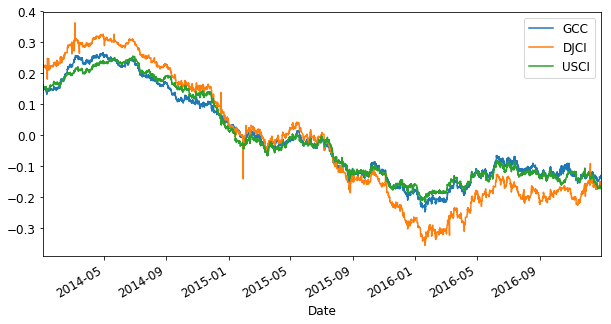

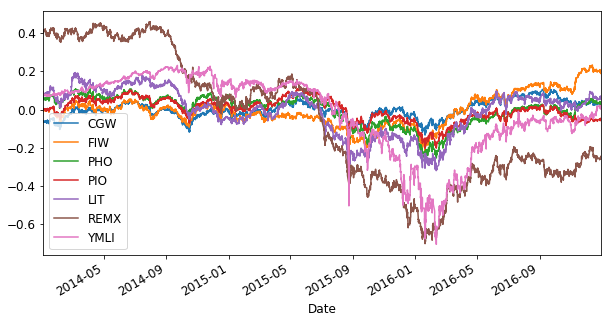

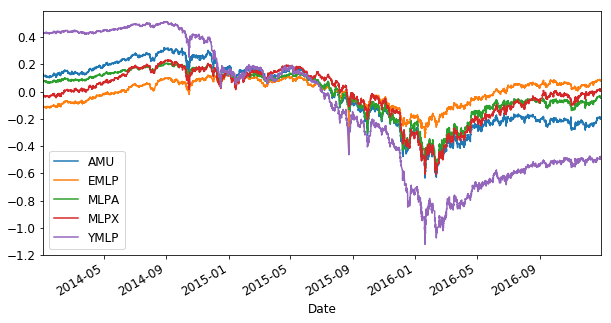

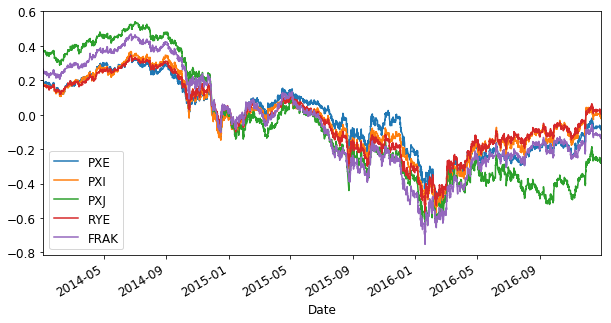

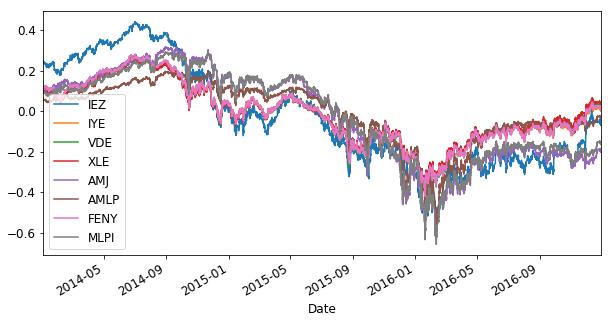

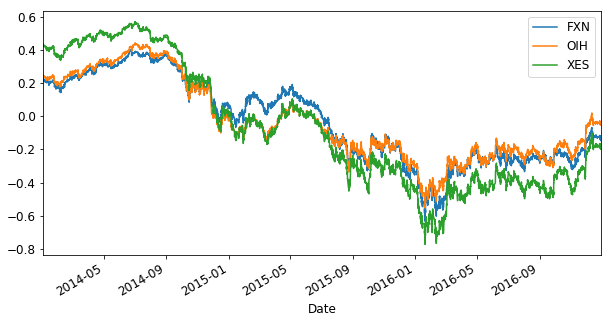

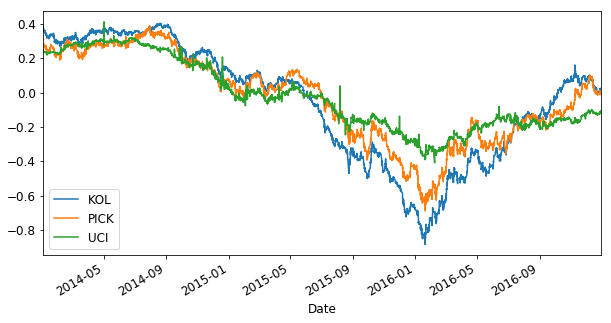

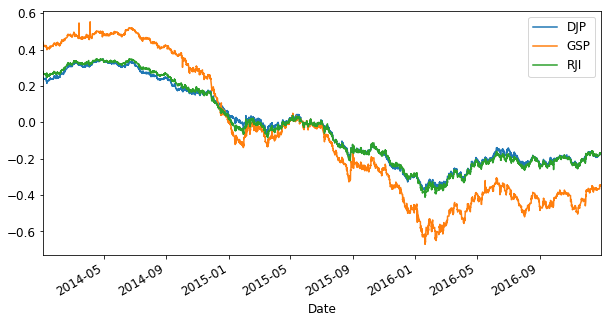

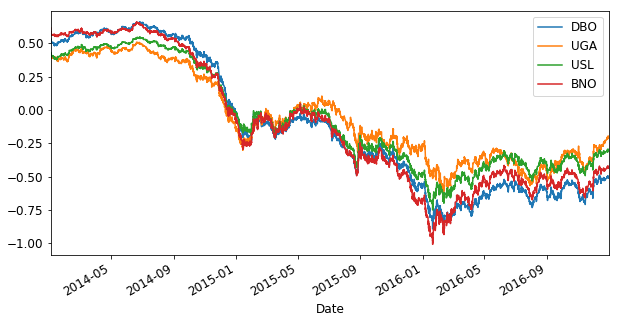

In [78]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(figsize=(10,5))#title='ETFs Time Series for Cluster %d' % (clust+1))
    #plt.ylabel('Normalized log prices', size=12)
    #plt.xlabel('Date', size=12)
    plt.savefig('cluster_{}.png'.format(str(clust+1)), bbox_inches='tight', pad_inches=0.1)

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [21]:
pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.10,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )

Cluster 17/17Found 32 pairs
The pairs contain 36 unique tickers
Pairs Selection failed stage:  {'cointegration': 95, 'None': 32, 'half_life': 2}


In [23]:
with open('data/etfs/pickle/2015-2019/pairs_unsupervised_learning_optical_'+file_extension+'_p005_seed0.pickle', 'wb') as f:
    pickle.dump(pairs_unsupervised, f)

19


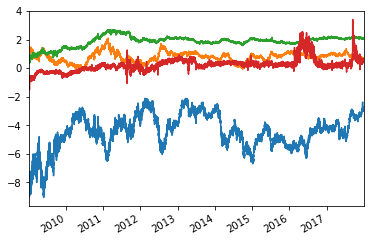

In [339]:
for i in range(len(pairs_aux)):
    pairs_aux[i][2]['spread'].plot()

In [318]:
for i in range(len(pairs_aux)):
    print(pairs_aux[i][2]['zero_cross'])

322
500
458
826
627
1234


In [363]:
count_different_category = 0
for pair in pairs_aux:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], df_category.loc[pair[0]]['Segment'] ,
                                                        df_category.loc[pair[0]]['Category']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], df_category.loc[pair[1]]['Segment'],
                                                        df_category.loc[pair[1]]['Category']))
    if df_category.loc[pair[0]]['Category'] != df_category.loc[pair[1]]['Category']:
        count_different_category += 1
print('There are {} pairs from different categories'.format(count_different_category))

------------------------------------------------
Leg 1: DBA. Segment: Commodities: Agriculture. Category: Agriculture
Leg 2: GCC. Segment: Commodities: Broad Market. Category: Broad Market
------------------------------------------------
Leg 1: GCC. Segment: Commodities: Broad Market. Category: Broad Market
Leg 2: RJA. Segment: Commodities: Agriculture. Category: Agriculture
------------------------------------------------
Leg 1: GSG. Segment: Commodities: Broad Market. Category: Broad Market
Leg 2: RJI. Segment: Commodities: Broad Market. Category: Broad Market
------------------------------------------------
Leg 1: DGP. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
Leg 2: UGL. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
There are 2 pairs from different categories
